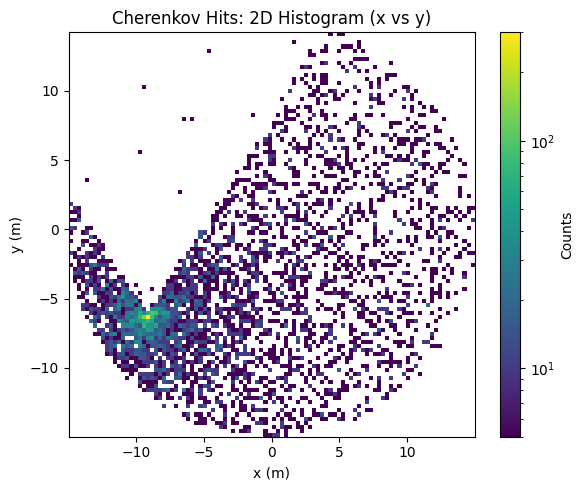

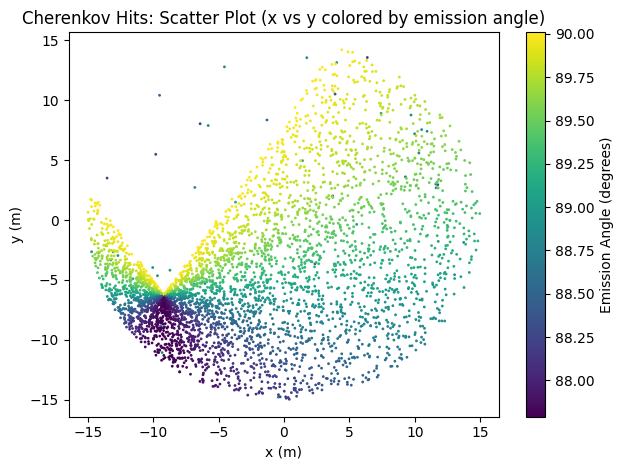

In [2]:
#Cherenkov histogram with curve option
import pandas as pd

# Path to your Cherenkov hits CSV file
csv_path = "/uufs/chpc.utah.edu/common/home/u1520754/corsika8_output/cherenkov_hits.csv"

# Read the CSV into a pandas DataFrame
hits = pd.read_csv(csv_path)

# Your data
import numpy as np
R_E = 6371000  # Earth's radius in meters
w = np.array(hits["wavelength_nm"])
t = np.array(hits["time_ns"])
H = np.array(hits["z_production_m"]) - R_E
x_c = np.array(hits["x_m"])
y_c = np.array(hits["y_m"])
r_c = np.sqrt(x_c**2 + y_c**2)
z_c = np.array(hits["z_m"])
dir_x = np.array(hits["dir_x"])
dir_y = np.array(hits["dir_y"])
dir_z = np.array(hits["dir_z"])
weight = np.array(hits["weight"])  # <-- ADD THIS
n_minus_1 = np.array(hits["n_minus_1"])  # <-- ADD THIS
path = np.array(hits["path_length_m"])  # <-- ADD THIS
dir_ground_x = np.array(hits["dir_ground_x"])
dir_ground_y = np.array(hits["dir_ground_y"])
dir_ground_z = np.array(hits["dir_ground_z"])
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# Assuming your DataFrame from the previous cell is called `hits`
# and has columns named "x" and "y"

plt.figure(figsize=(6, 5))

h = plt.hist2d(
    hits["x_m"],
    hits["y_m"],
    bins=100,          # adjust binning as needed
    cmap="viridis",
    #range=[[-15, 15], [-15, 15]],
    #range=[[-5, 5], [-5, 5]],
    weights=hits["weight"],
    norm=LogNorm()  # use logarithmic color scale
)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Cherenkov Hits: 2D Histogram (x vs y)")
plt.colorbar(h[3], label="Counts")
plt.tight_layout()
plt.show()

emission_angle = np.degrees(np.arccos(-dir_ground_z))
plt.scatter(x_c, y_c, c=emission_angle, s=1, cmap='viridis')#, norm=LogNorm())
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Cherenkov Hits: Scatter Plot (x vs y colored by emission angle)")
plt.colorbar(label="Emission Angle (degrees)")
plt.tight_layout()
plt.show()


📦 EXTRACTING PARTICLE DATA (CORRECTED VERSION)

✅ Loaded 10 particles
   Columns: ['shower', 'pdg', 'kinetic_energy', 'x', 'y', 'nx', 'ny', 'nz', 'time', 'weight']

✅ Direction vector normalization check: 1.000000 ± 0.000000

📊 CORRECTED DATA SUMMARY

🔬 Particle Composition:
   e⁺     (PDG    -11):    1 ( 10.0%)  weighted:      1.0 ( 10.0%)  <E>=6.39e-02 GeV
   e⁻     (PDG     11):    1 ( 10.0%)  weighted:      1.0 ( 10.0%)  <E>=1.87e+00 GeV
   μ⁻     (PDG     13):    1 ( 10.0%)  weighted:      1.0 ( 10.0%)  <E>=1.00e+05 GeV
   γ      (PDG     22):    7 ( 70.0%)  weighted:      7.0 ( 70.0%)  <E>=6.27e-02 GeV

📍 Position Distribution:
   X range:        [     -7.89,       4.23] m
   Y range:        [   -200.98,       1.86] m
   Radius range:   [0.00, 201.02] m
   Mean radius:    23.91 m
   Median radius:  5.35 m

   Radial containment:
      50% of particles within       5.35 m (5 particles)
      68% of particles within       8.18 m (7 particles)
      90% of particles within      28.8

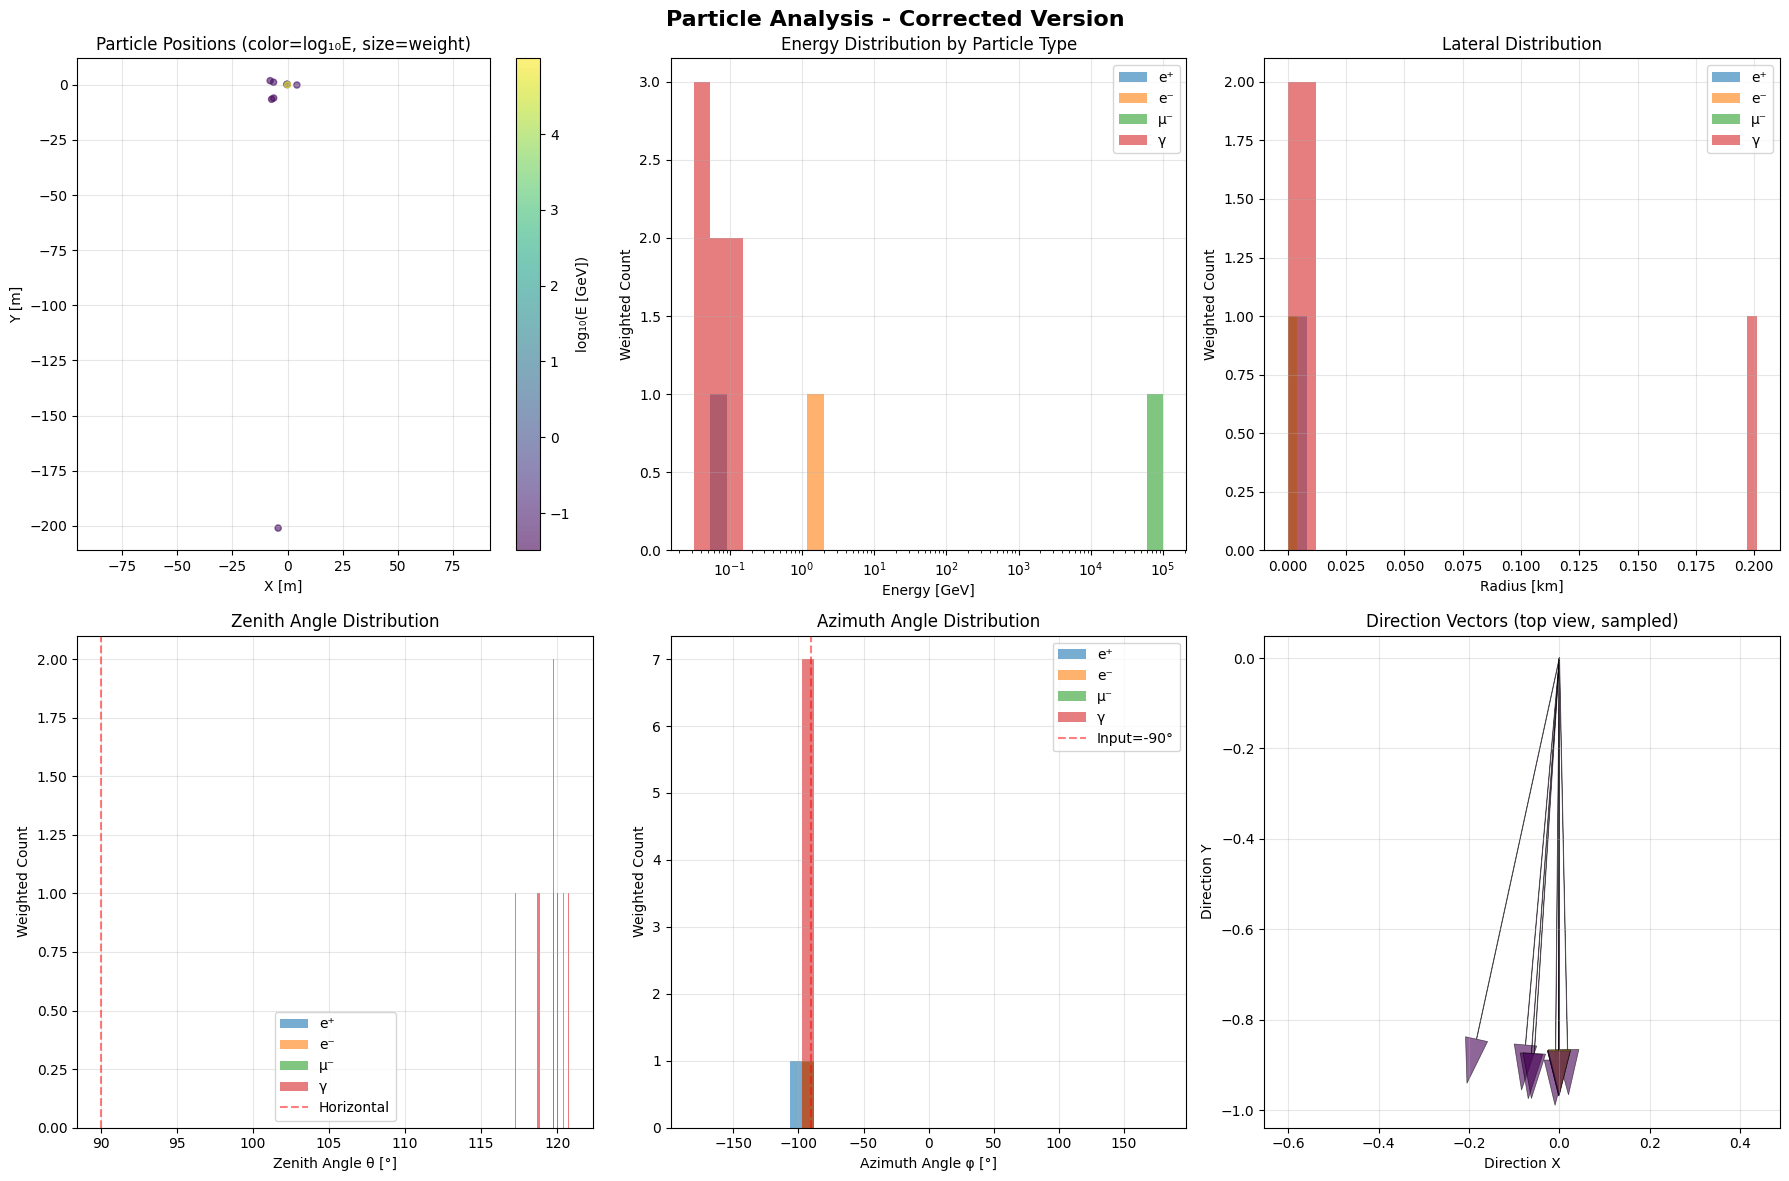

In [27]:
# extract_particles_FIXED.py
import pyarrow.parquet as pq
import numpy as np
import pandas as pd

def get_particle_name(pdg):
    """Convert PDG code to particle name"""
    pdg_map = {
        11: "e⁻", -11: "e⁺", 13: "μ⁻", -13: "μ⁺",
        22: "γ", 111: "π⁰", 211: "π⁺", -211: "π⁻",
        2212: "p", -2212: "p̄", 2112: "n", -2112: "n̄",
        321: "K⁺", -321: "K⁻", 130: "K_L", 310: "K_S"
    }
    return pdg_map.get(pdg, f"PDG_{pdg}")

# Load the particle data
base_dir = "/uufs/chpc.utah.edu/common/home/u1520754/corsika8_output_2/muon_test"
particles_file = f"{base_dir}/particles/particles.parquet"

print("=" * 90)
print("📦 EXTRACTING PARTICLE DATA (CORRECTED VERSION)")
print("=" * 90)

# Read parquet file
df = pq.read_table(particles_file).to_pandas()

print(f"\n✅ Loaded {len(df)} particles")
print(f"   Columns: {list(df.columns)}\n")

# ========================================
# EXTRACT DATA - CORRECTED VERSION
# ========================================

# Particle types
pdg_codes = df['pdg'].values.astype(int)
particle_names = np.array([get_particle_name(p) for p in pdg_codes])

# Positions (x, y, z) in meters
x_pos = df['x'].values  # meters
y_pos = df['y'].values  # meters
z_pos = np.zeros(len(df))  # ground level

# Radius from shower axis
radius = np.sqrt(x_pos**2 + y_pos**2)

# Energy in GeV
energy = df['kinetic_energy'].values  # CORRECTED: was 'energy', should be 'kinetic_energy'

# Direction vectors - CORRECTED VERSION
# CORSIKA stores nx, ny, nz which are ALREADY NORMALIZED direction cosines
dir_x = df['nx'].values
dir_y = df['ny'].values
dir_z = df['nz'].values

# Verify normalization (should be ~1.0)
dir_norm = np.sqrt(dir_x**2 + dir_y**2 + dir_z**2)
print(f"✅ Direction vector normalization check: {dir_norm.mean():.6f} ± {dir_norm.std():.6f}")

# Calculate angles from direction cosines
# θ (zenith): angle from vertical (z-axis)
# φ (azimuth): angle in x-y plane from x-axis
theta = np.arccos(np.clip(dir_z, -1, 1)) * 180 / np.pi  # zenith angle (0°=down, 90°=horizontal)
phi = np.arctan2(dir_y, dir_x) * 180 / np.pi  # azimuth angle (-180° to 180°)

# Time
time = df['time'].values if 'time' in df.columns else np.zeros(len(df))

# Weight (for thinning)
weight = df['weight'].values if 'weight' in df.columns else np.ones(len(df))

# ========================================
# CREATE DATA STRUCTURES
# ========================================

# Structured numpy array with ALL information
particle_data = np.array([
    (pdg, name, x, y, z, r, e, dx, dy, dz, th, ph, t, w)
    for pdg, name, x, y, z, r, e, dx, dy, dz, th, ph, t, w in zip(
        pdg_codes, particle_names, x_pos, y_pos, z_pos, radius, energy,
        dir_x, dir_y, dir_z, theta, phi, time, weight
    )
], dtype=[
    ('pdg', 'i4'),
    ('name', 'U10'),
    ('x', 'f8'), ('y', 'f8'), ('z', 'f8'),
    ('radius', 'f8'),
    ('energy', 'f8'),
    ('dir_x', 'f8'), ('dir_y', 'f8'), ('dir_z', 'f8'),
    ('theta', 'f8'), ('phi', 'f8'),
    ('time', 'f8'),
    ('weight', 'f8')
])

# Dictionary version (easier access)
particles = {
    'pdg': pdg_codes,
    'name': particle_names,
    'position': {
        'x': x_pos,
        'y': y_pos,
        'z': z_pos,
        'radius': radius
    },
    'direction': {
        'x': dir_x,
        'y': dir_y,
        'z': dir_z,
        'theta': theta,
        'phi': phi
    },
    'energy': energy,
    'time': time,
    'weight': weight
}

# ========================================
# SUMMARY WITH CORRECT CALCULATIONS
# ========================================

print("\n" + "=" * 90)
print("📊 CORRECTED DATA SUMMARY")
print("=" * 90)

print(f"\n🔬 Particle Composition:")
unique_pdg, counts = np.unique(pdg_codes, return_counts=True)
total_weight = weight.sum()
for pdg, count in zip(unique_pdg, counts):
    name = get_particle_name(pdg)
    mask = pdg_codes == pdg
    e_sum = energy[mask].sum()
    e_mean = energy[mask].mean()
    w_sum = weight[mask].sum()
    pct = 100 * count / len(pdg_codes)
    pct_w = 100 * w_sum / total_weight
    print(f"   {name:6s} (PDG {pdg:6d}): {count:4d} ({pct:5.1f}%)  "
          f"weighted: {w_sum:8.1f} ({pct_w:5.1f}%)  "
          f"<E>={e_mean:.2e} GeV")

print(f"\n📍 Position Distribution:")
print(f"   X range:        [{x_pos.min():10.2f}, {x_pos.max():10.2f}] m")
print(f"   Y range:        [{y_pos.min():10.2f}, {y_pos.max():10.2f}] m")
print(f"   Radius range:   [0.00, {radius.max():.2f}] m")
print(f"   Mean radius:    {radius.mean():.2f} m")
print(f"   Median radius:  {np.median(radius):.2f} m")

# Show radial distribution
percentiles = [50, 68, 90, 95, 99]
print(f"\n   Radial containment:")
for p in percentiles:
    r_p = np.percentile(radius, p)
    n_inside = (radius <= r_p).sum()
    print(f"      {p:2d}% of particles within {r_p:10.2f} m ({n_inside} particles)")

print(f"\n⚡ Energy Distribution:")
print(f"   Total energy:    {energy.sum():.4e} GeV")
print(f"   Weighted energy: {(energy * weight).sum():.4e} GeV")
print(f"   Mean energy:     {energy.mean():.4e} GeV")
print(f"   Median energy:   {np.median(energy):.4e} GeV")
print(f"   Energy range:    [{energy.min():.4e}, {energy.max():.4e}] GeV")

print(f"\n🧭 Direction Distribution (CORRECTED):")
print(f"   Zenith angle (θ):")
print(f"      Mean:   {theta.mean():6.2f}° ± {theta.std():.2f}°")
print(f"      Median: {np.median(theta):6.2f}°")
print(f"      Range:  [{theta.min():6.2f}°, {theta.max():6.2f}°]")
print(f"\n   Azimuth angle (φ):")
print(f"      Mean:   {phi.mean():6.2f}° ± {phi.std():.2f}°")
print(f"      Median: {np.median(phi):6.2f}°")
print(f"      Range:  [{phi.min():6.2f}°, {phi.max():6.2f}°]")

# Analyze by particle type
print(f"\n📈 Direction by Particle Type:")
for pdg in unique_pdg:
    name = get_particle_name(pdg)
    mask = pdg_codes == pdg
    if mask.sum() > 0:
        print(f"   {name:6s}: θ={theta[mask].mean():6.2f}° ± {theta[mask].std():5.2f}°  "
              f"φ={phi[mask].mean():6.2f}° ± {phi[mask].std():5.2f}°")

# ========================================
# VISUALIZATIONS
# ========================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Particle Analysis - Corrected Version', fontsize=16, fontweight='bold')

# 1. Position scatter (top view)
ax = axes[0, 0]
scatter = ax.scatter(x_pos, y_pos, c=np.log10(energy+1e-6), s=20*weight, 
                    alpha=0.6, cmap='viridis')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Particle Positions (color=log₁₀E, size=weight)')
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.colorbar(scatter, ax=ax, label='log₁₀(E [GeV])')

# 2. Energy distribution
ax = axes[0, 1]
bins = np.logspace(np.log10(energy.min()), np.log10(energy.max()), 30)
for pdg in unique_pdg:
    name = get_particle_name(pdg)
    mask = pdg_codes == pdg
    ax.hist(energy[mask], bins=bins, alpha=0.6, label=name, weights=weight[mask])
ax.set_xscale('log')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('Weighted Count')
ax.set_title('Energy Distribution by Particle Type')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Radial distribution
ax = axes[0, 2]
bins = np.linspace(0, radius.max(), 50)
for pdg in unique_pdg:
    name = get_particle_name(pdg)
    mask = pdg_codes == pdg
    ax.hist(radius[mask]/1000, bins=bins/1000, alpha=0.6, label=name, weights=weight[mask])
ax.set_xlabel('Radius [km]')
ax.set_ylabel('Weighted Count')
ax.set_title('Lateral Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Zenith angle distribution
ax = axes[1, 0]
bins = np.linspace(theta.min(), theta.max(), 40)
for pdg in unique_pdg:
    name = get_particle_name(pdg)
    mask = pdg_codes == pdg
    ax.hist(theta[mask], bins=bins, alpha=0.6, label=name, weights=weight[mask])
ax.set_xlabel('Zenith Angle θ [°]')
ax.set_ylabel('Weighted Count')
ax.set_title('Zenith Angle Distribution')
ax.axvline(90, color='red', linestyle='--', alpha=0.5, label='Horizontal')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Azimuth angle distribution
ax = axes[1, 1]
bins = np.linspace(-180, 180, 40)
for pdg in unique_pdg:
    name = get_particle_name(pdg)
    mask = pdg_codes == pdg
    ax.hist(phi[mask], bins=bins, alpha=0.6, label=name, weights=weight[mask])
ax.set_xlabel('Azimuth Angle φ [°]')
ax.set_ylabel('Weighted Count')
ax.set_title('Azimuth Angle Distribution')
ax.axvline(-90, color='red', linestyle='--', alpha=0.5, label='Input=-90°')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. 3D direction plot (arrows on sphere)
ax = axes[1, 2]
# Sample particles for clarity
n_sample = min(50, len(particles['pdg']))
idx_sample = np.random.choice(len(particles['pdg']), n_sample, replace=False)

# Convert to Cartesian for plotting
for idx in idx_sample:
    ax.arrow(0, 0, dir_x[idx], dir_y[idx], head_width=0.05, head_length=0.1,
            fc=plt.cm.viridis(np.log10(energy[idx]+1e-6)/np.log10(energy.max())),
            ec='black', linewidth=0.5, alpha=0.6)
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel('Direction X')
ax.set_ylabel('Direction Y')
ax.set_title('Direction Vectors (top view, sampled)')
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.show()





📂 Loading particle data...
✅ Loaded 2580 production vertices
   Columns: ['shower', 'X', 'charged', 'hadron', 'photon', 'electron', 'positron', 'muplus', 'muminus']


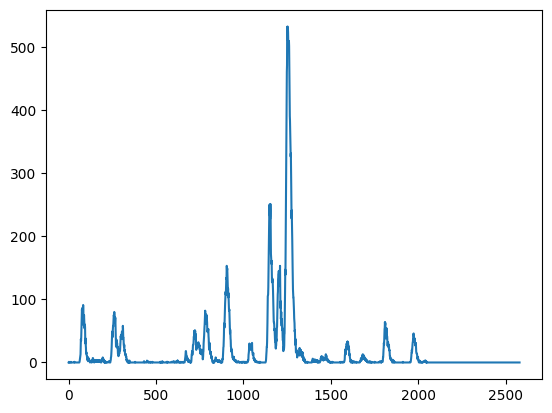

In [2]:
base_dir = "/uufs/chpc.utah.edu/common/home/u1520754/corsika8_output/muon_test"

# ========================================
# LOAD ALL AVAILABLE DATA
# ========================================

print("\n📂 Loading particle data...")

production_df = pq.read_table(f"{base_dir}/profile/profile.parquet").to_pandas()
print(f"✅ Loaded {len(production_df)} production vertices")
print(f"   Columns: {list(production_df.columns)}")
plt.plot(np.array(production_df["electron"]))